## Import Required Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [6]:
train_dir = 'Train'
test_dir = 'Test'
val_dir = 'Validation'
import tensorflow as tf
print(tf.__version__)

2.15.0


### Let's view some of the images of **Train** Dataset

In [7]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_validation = image_dataset_from_directory(val_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_test = image_dataset_from_directory(test_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)


Found 10000 files belonging to 2 classes.
Found 802 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


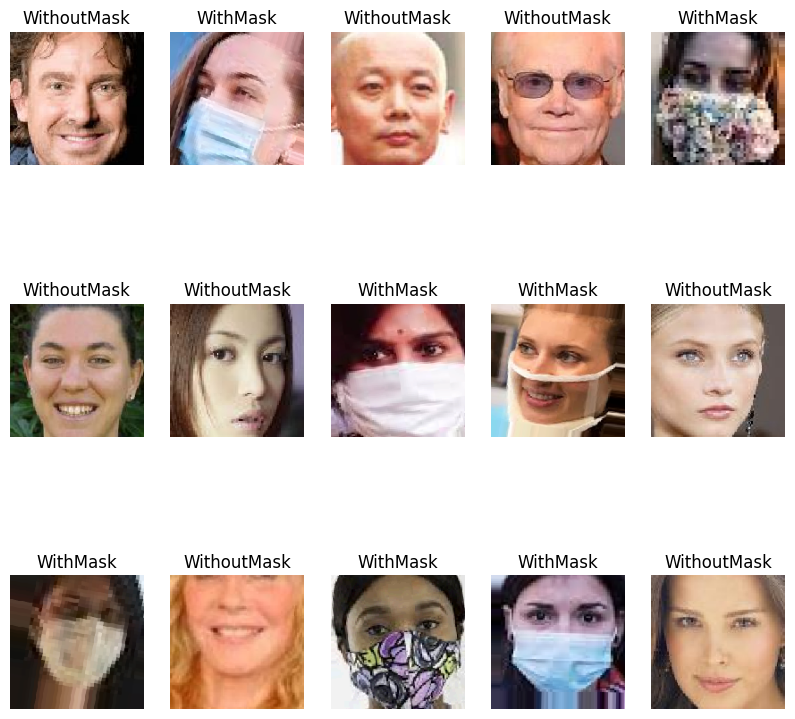

In [8]:
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')
        
        
# from IPython.display import clear_output
clear_output()

## Data Augmentation

In [9]:
# Image size
IMG_SIZE = (256, 256)

# data argumentation
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                       rotation_range=45,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )

# data argumentation
test_datagen = ImageDataGenerator(rescale= 1 / 255.0)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=200, 
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


## MobileNetV2 Base Model

In [10]:
# using mobilenetv2 model
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(256,256,3))
# make pre trained model into non trainable bcoz its takes much time
for layer in mobilenet.layers:
    layer.trainable = False

## Transfer Learning

In [11]:
# Initialize the model in sequential
model = Sequential()
# add MobileNetV2 model into our sequence model
model.add(mobilenet)
# flatten the model
model.add(Flatten())
# Adding dense layers
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
# Adding output layer
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 128)               10485888  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 12744130 (48.61 MB)
Trainable params: 10486146 (40.00 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Compile the Model

In [13]:
# model compile
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

## Model Fitting

In [14]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found. Please ensure you have a GPU and the necessary drivers installed.")

# Assuming 'model' is a TensorFlow model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    verbose=1)

No GPU found. Please ensure you have a GPU and the necessary drivers installed.
Epoch 1/5


50/50 [==============================] - 242s 5s/step - loss: 2.3115 - accuracy: 0.8881 - val_loss: 0.0840 - val_accuracy: 0.9663
Epoch 2/5
50/50 [==============================] - 189s 4s/step - loss: 0.0812 - accuracy: 0.9709 - val_loss: 0.0518 - val_accuracy: 0.9850
Epoch 3/5
50/50 [==============================] - 186s 4s/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 0.0483 - val_accuracy: 0.9863
Epoch 4/5
50/50 [==============================] - 181s 4s/step - loss: 0.0392 - accuracy: 0.9879 - val_loss: 0.0428 - val_accuracy: 0.9900
Epoch 5/5
50/50 [==============================] - 187s 4s/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.0360 - val_accuracy: 0.9888


In [15]:
model.evaluate(validation_dataset)

13/13 [==============================] - 14s 1s/step - loss: 0.0444 - accuracy: 0.9863


[0.04443557187914848, 0.9862843155860901]

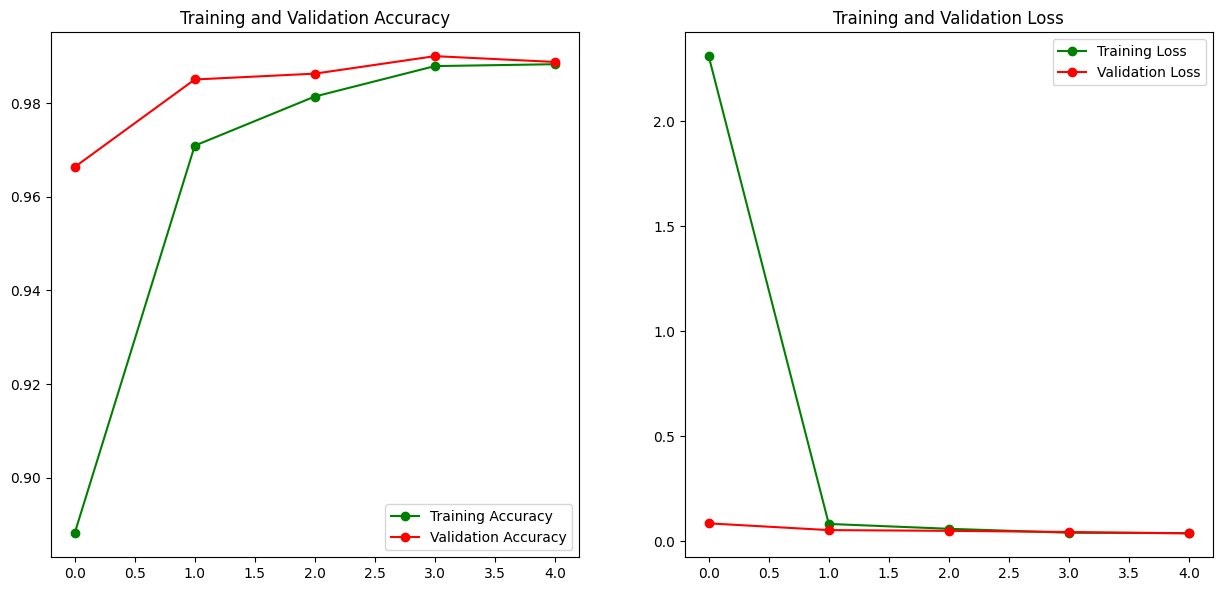

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,"go-", label='Training Accuracy')
plt.plot(epochs_range, val_acc,"ro-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss,"go-", label='Training Loss')
plt.plot(epochs_range, val_loss,"ro-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Prediction

In [17]:
test_pred = model.predict(test_dataset)

16/16 [==============================] - 17s 1s/step


In [18]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

1    504
0    488
Name: count, dtype: int64


In [ ]:
def img_preprocessing(path):
    sample_mask_img = cv2.imread(path)
    if sample_mask_img is not None:
        sample_mask_img = cv2.resize(sample_mask_img,(256,256))
        plt.imshow(sample_mask_img)
        sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
        sample_mask_img = sample_mask_img/255.0
        res = np.argmax(model.predict(sample_mask_img))
        print('            ', colored(classes_train[res], "red"))
    else:
        print("Failed to load image:", path)


1/1 [==============================] - 1s 998ms/step
             WithoutMask


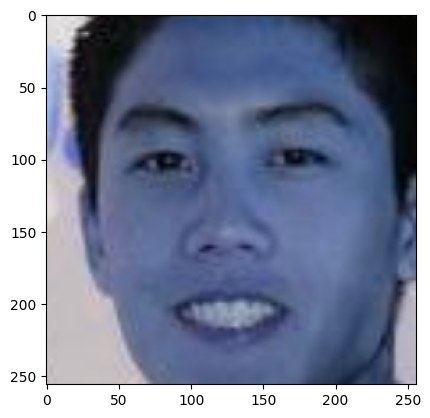

In [20]:
img_preprocessing('Validation/WithoutMask/5314.png')

1/1 [==============================] - 0s 50ms/step
             WithMask


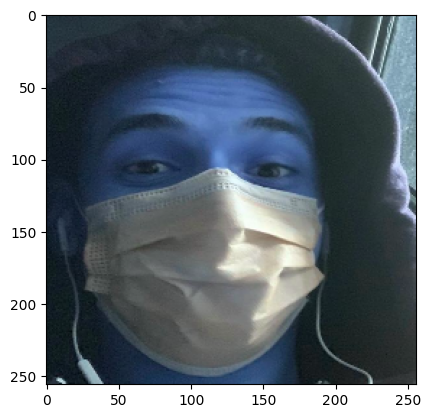

In [21]:
img_preprocessing('Validation/WithMask/h.jpg')

1/1 [==============================] - 0s 50ms/step
             WithoutMask


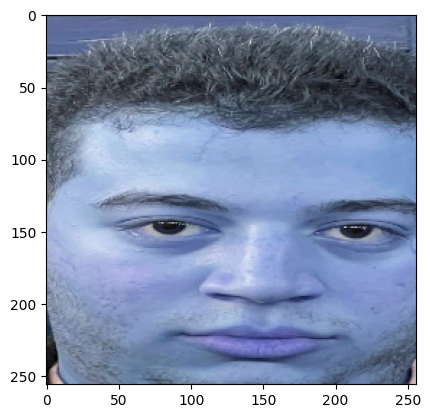

In [41]:
img_preprocessing('Validation/WithoutMask/bad2.jpg')